In [ ]:
import os
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, Sampler

import uproot
import h5py
from HighLevelFeatures import HighLevelFeatures as HLF
from XMLHandler import XMLHandler

import dgl
from dgl import backend as F

from tqdm import tqdm

In [ ]:
HLF_1_photons = HLF('photon', filename='../data/binning_dataset_1_photons.xml')
print(HLF_1_photons.eta_all_layers, "\n\n", HLF_1_photons.phi_all_layers)
photon_file = h5py.File('../data/dataset_1_photons_1.hdf5', 'r')

In [ ]:
for dataset in photon_file:
    # name of the datasets:
    print("dataset name: ", dataset)
    print("dataset shape:", photon_file[dataset][:].shape)

[[  16384.]
 [ 524288.]
 [1048576.]
 ...
 [  32768.]
 [   4096.]
 [ 131072.]]


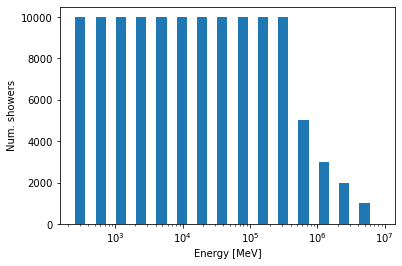

In [14]:
energies = photon_file['incident_energies'][:]
print(energies)

bins = np.logspace(8,23,31, base=2)
plt.hist(energies, bins=bins)
plt.xscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Num. showers')
plt.show()

In [15]:
HLF_1_photons.CalculateFeatures(photon_file["showers"][:])

print("Total energy of each photon shower: ", HLF_1_photons.GetEtot())
print("Average total energy of the photon showers: ", HLF_1_photons.GetEtot().mean())

print("Energy deposited in each layer for each photon shower: ", HLF_1_photons.GetElayers())
print("Average energy deposited in the first layer for photon showers: ", HLF_1_photons.GetElayers()[0].mean())
print("Average energy deposited in the last layer for photon showers: ", HLF_1_photons.GetElayers()[12].mean())

print("Center of energy in eta direction for each photon shower: ", HLF_1_photons.GetECEtas())
print("Width of center of energy in eta direction for each photon shower: ", HLF_1_photons.GetWidthEtas())

print("Center of energy in phi direction for each photon shower: ", HLF_1_photons.GetECPhis())
print("Width of center of energy in phi direction for each photon shower: ", HLF_1_photons.GetWidthEtas())

Total energy of each photon shower:  [  15868.88430233  513568.649219   1012206.5217699  ...   32717.0473327
    3935.16104002  127088.6041893 ]
Average total energy of the photon showers:  154970.80067222245
Energy deposited in each layer for each photon shower:  {0: array([397.90284 , 335.22051 , 458.715706, ...,   3.021411,  89.36487 ,
       564.82    ]), 1: array([ 6619.20246733, 29872.39803   , 27366.20037   , ...,
        4400.6388477 ,  1868.74613022, 27831.961346  ]), 2: array([  8844.038541 , 475911.127496 , 962300.9974939, ...,
        28158.736021 ,   1975.1564298,  98172.9360433]), 3: array([7.74045400e+00, 4.86087436e+03, 1.38063322e+04, ...,
       1.53001779e+02, 1.89361000e+00, 3.36691600e+02]), 12: array([0.00000000e+00, 2.58902882e+03, 8.27427600e+03, ...,
       1.64927400e+00, 0.00000000e+00, 1.82195200e+02])}
Average energy deposited in the first layer for photon showers:  360.01804784284496
Average energy deposited in the last layer for photon showers:  1397.3476

In [16]:
xml = XMLHandler("photon", filename='../data/binning_dataset_1_photons.xml')
bin_edges = xml.GetBinEdges()
eta_all_layers, phi_all_layers = xml.GetEtaPhiAllLayers()
relevantLayers = xml.GetRelevantLayers()
layersBinnedInAlpha = xml.GetLayersWithBinningInAlpha()
r_edges = [redge for redge in xml.r_edges if len(redge) > 1]
num_alpha = [len(xml.alphaListPerLayer[idx][0]) for idx, redge in enumerate(xml.r_edges) if len(redge) > 1]
E_tot = None
E_layers = {}
EC_etas = {}
EC_phis = {}
width_etas = {}
width_phis = {}
particle = "photon"

data = photon_file['showers'][:]

layer_boundaries = np.unique(bin_edges)
num_splits = 400
vmax = data.max()
max_r = 0

for layer in range(len(r_edges)):
    radii = np.array(r_edges[layer])
    radii[1:] = np.log(radii[1:])
    theta, rad = np.meshgrid(2.*np.pi*np.arange(num_splits+1)/ num_splits, radii)
    pts_per_angular_bin = int(num_splits / num_alpha[layer])

    data_reshaped = data[layer_boundaries[layer]:layer_boundaries[layer+1]].reshape(
        int(num_alpha[layer]), -1)

In [17]:
layer_boundaries

array([  0,   8, 168, 358, 363, 368])

In [40]:
data[:]

array([300.014 ,  94.0184, 176.159 , ...,   0.    ,  81.0009, 356.421 ])

In [19]:
data[layer_boundaries[0]:layer_boundaries[0+1]]

array([[3.00014e+02, 4.45615e+01, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [9.40184e+01, 0.00000e+00, 9.57449e+00, ..., 7.80987e+02,
        1.80680e+02, 3.61823e-01],
       [1.76159e+02, 0.00000e+00, 0.00000e+00, ..., 2.12393e+03,
        2.74176e+02, 0.00000e+00],
       ...,
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.16163e+02, 2.77424e+00, 1.21848e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [20]:
data[layer_boundaries[0]:layer_boundaries[0+1]].reshape(
        int(num_alpha[0]), -1)

array([[300.014 ,  44.5615,   0.    , ...,   0.    ,   0.    ,   0.    ]])

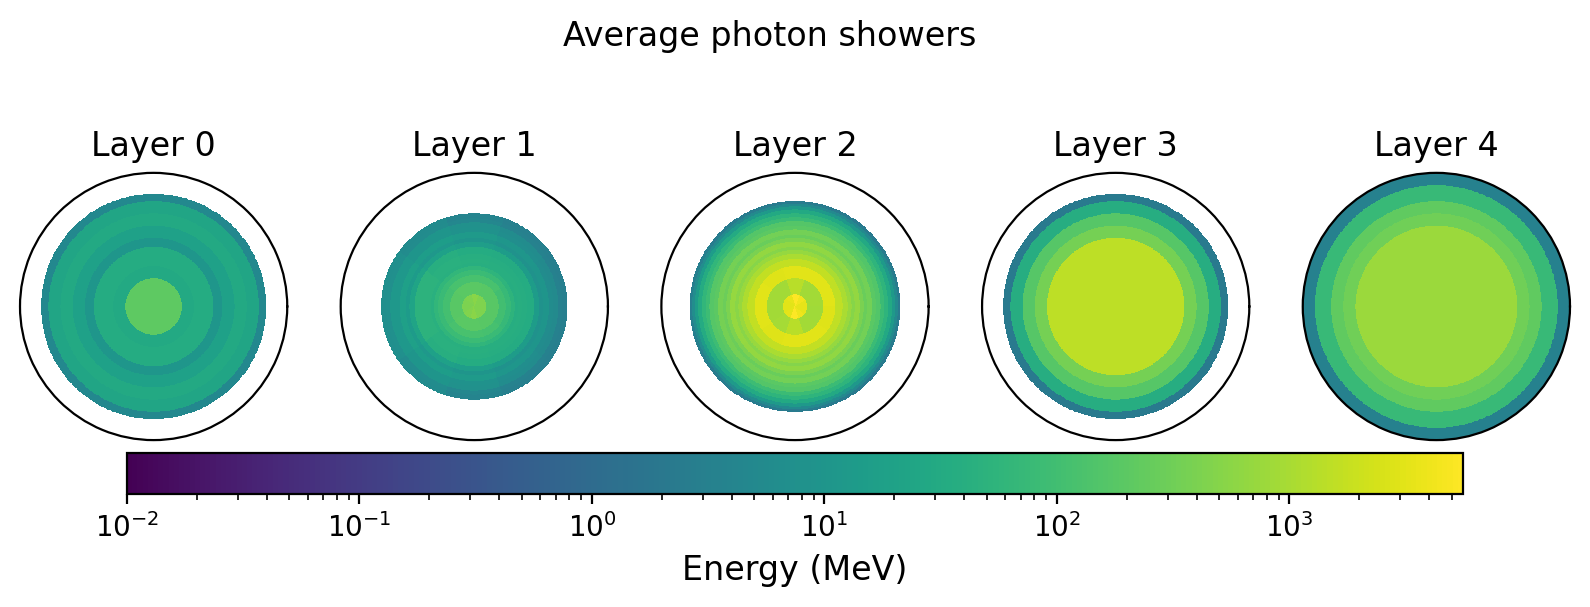

In [21]:
_ = HLF_1_photons.DrawAverageShower(photon_file['showers'][:], filename=None, title="Average photon showers")

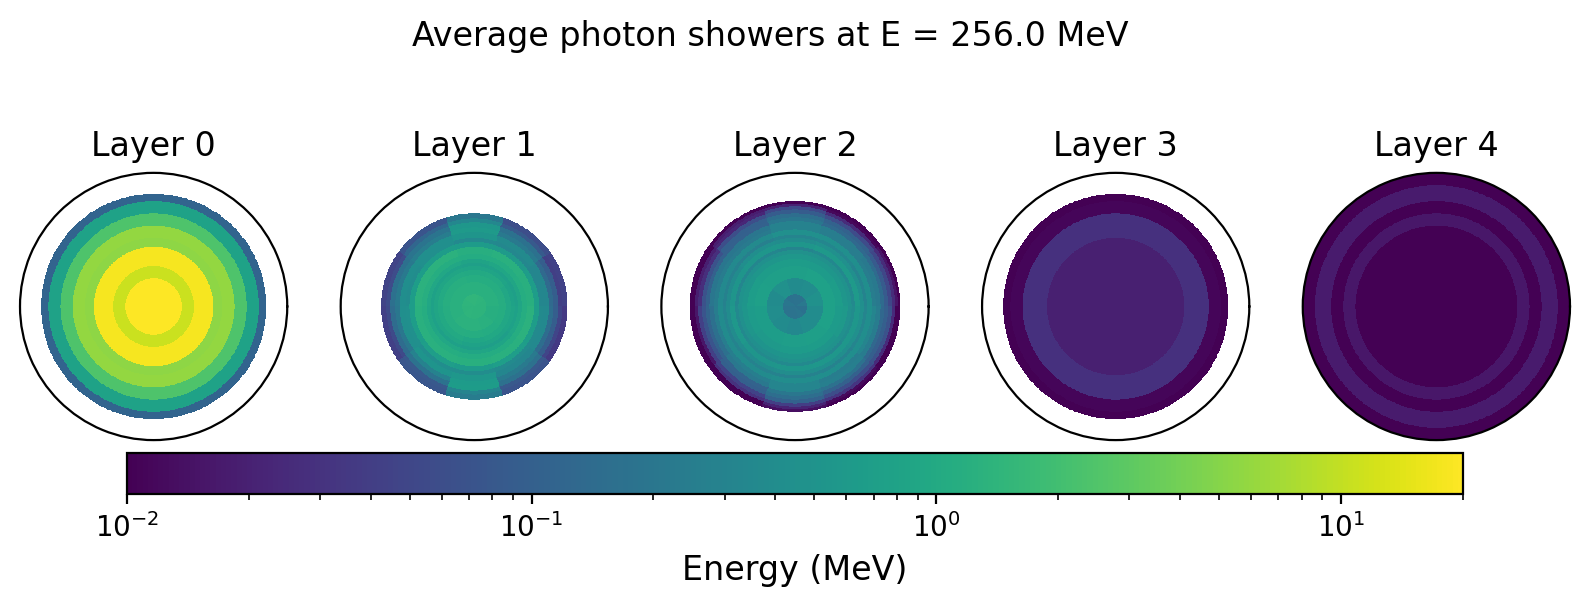

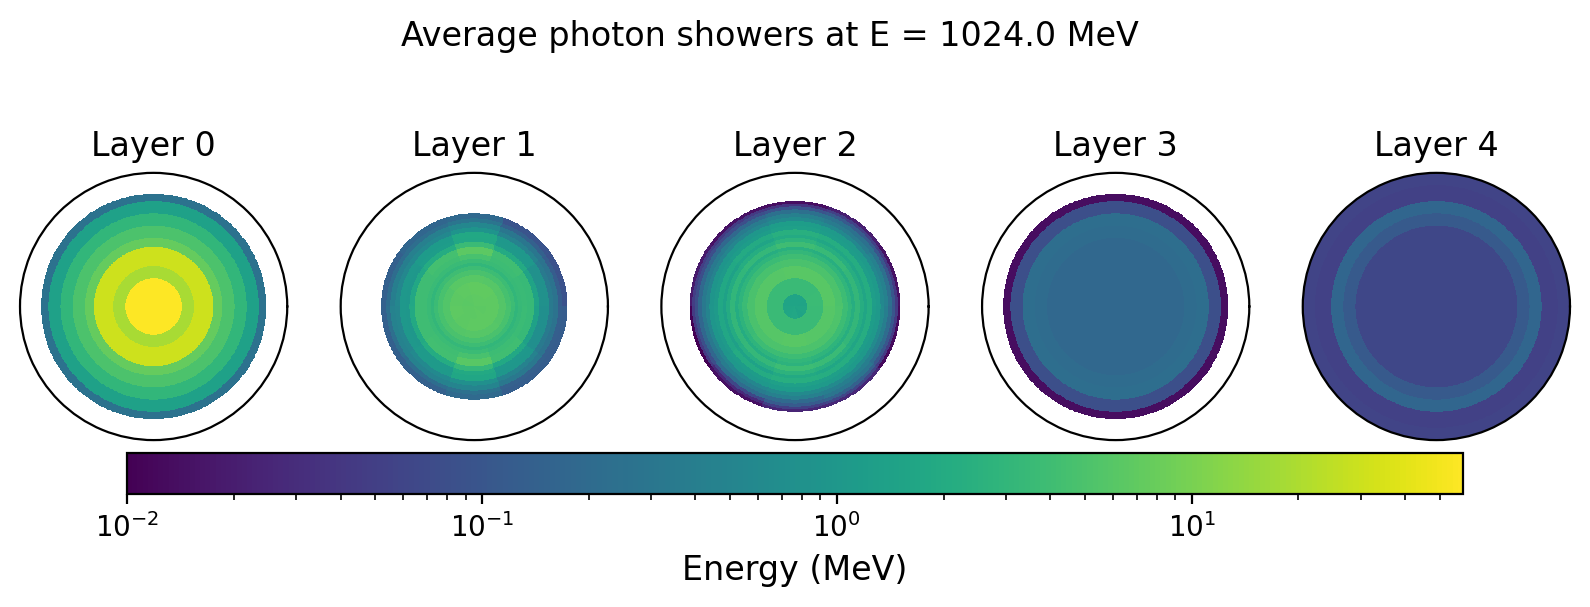

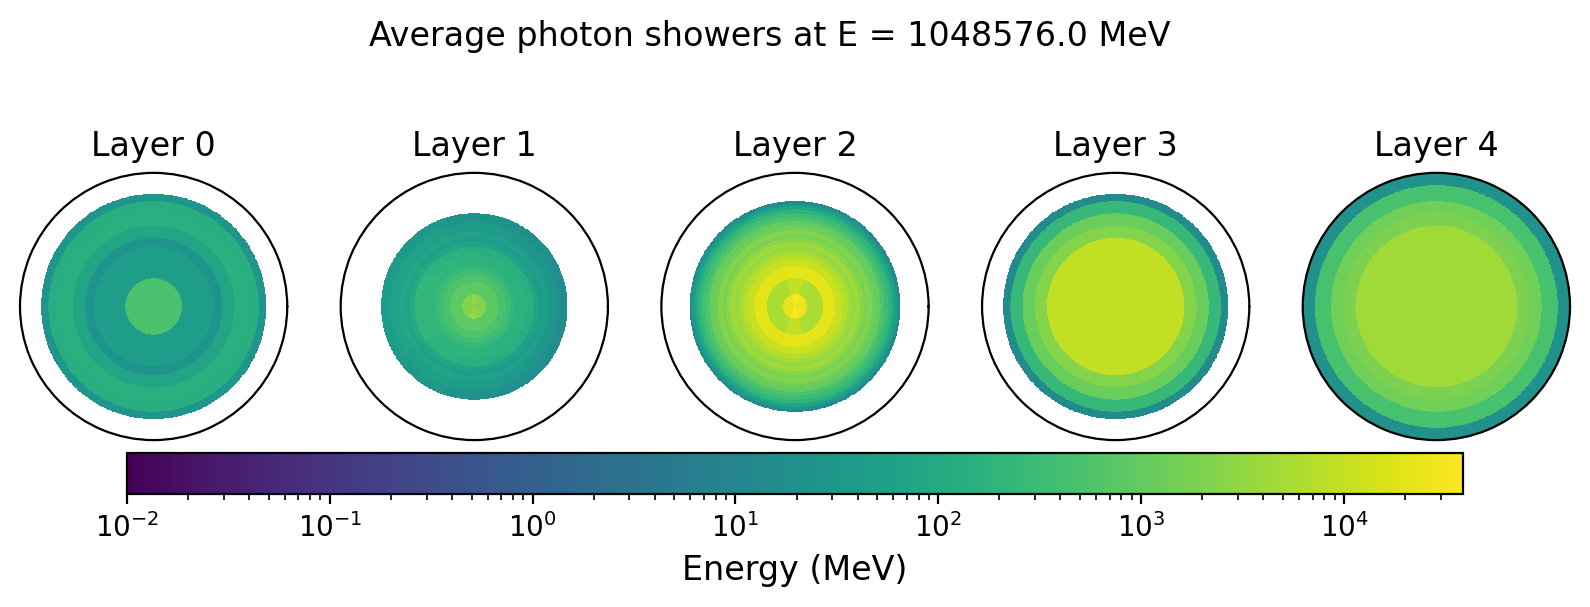

In [22]:
for energy in [256., 1024., 1048576.]:
    voxel_dim = photon_file['showers'].shape[1]
    # hdf5 indexing must match the shape of the dataset:
    energy_idx = np.tile(photon_file['incident_energies'][:]==energy, voxel_dim)
    # and then be reshaped:
    _ = HLF_1_photons.DrawAverageShower(photon_file['showers'][energy_idx].reshape(-1, voxel_dim),
                                        filename=None, title="Average photon showers at E = {} MeV".format(energy))

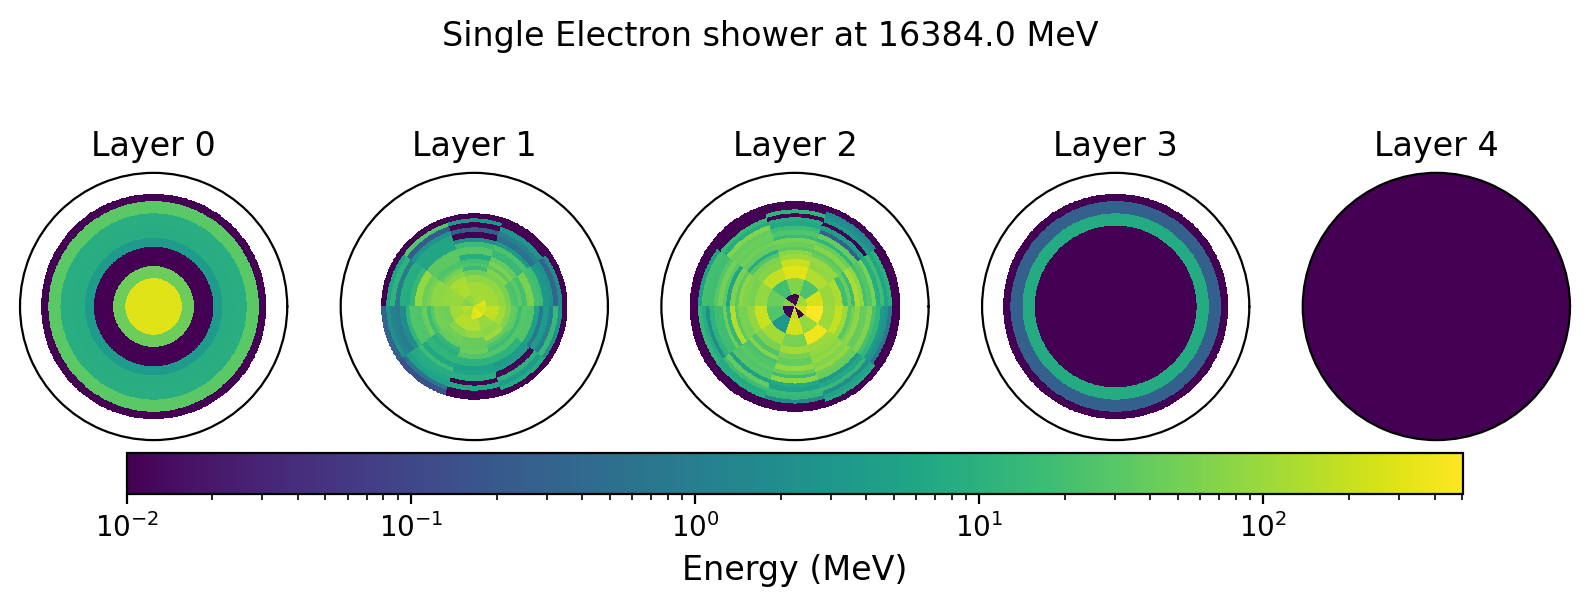

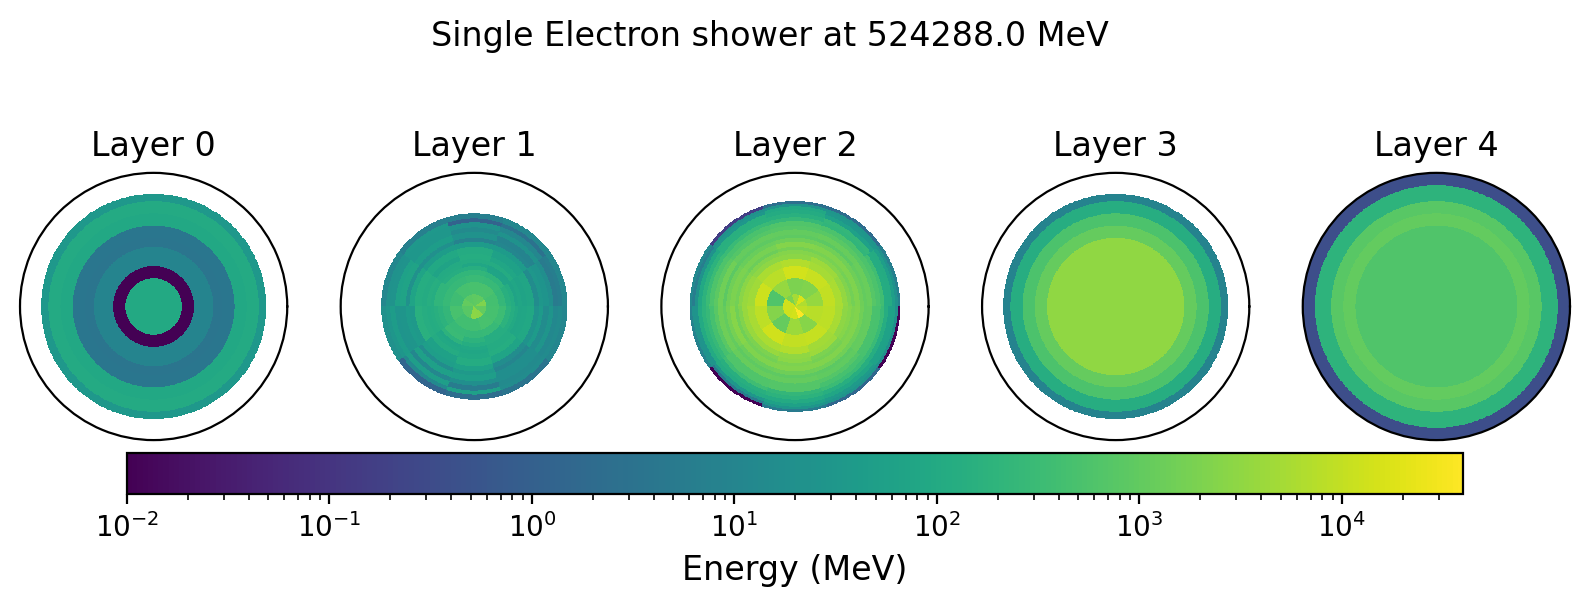

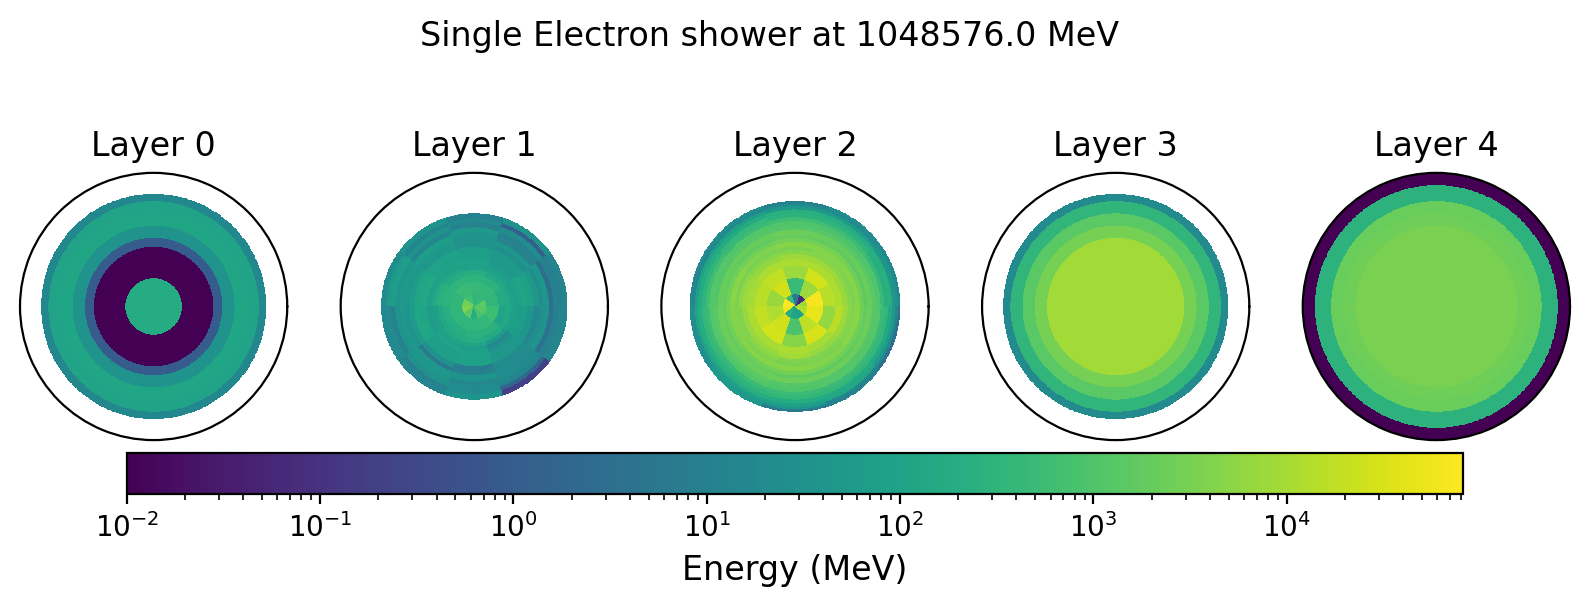

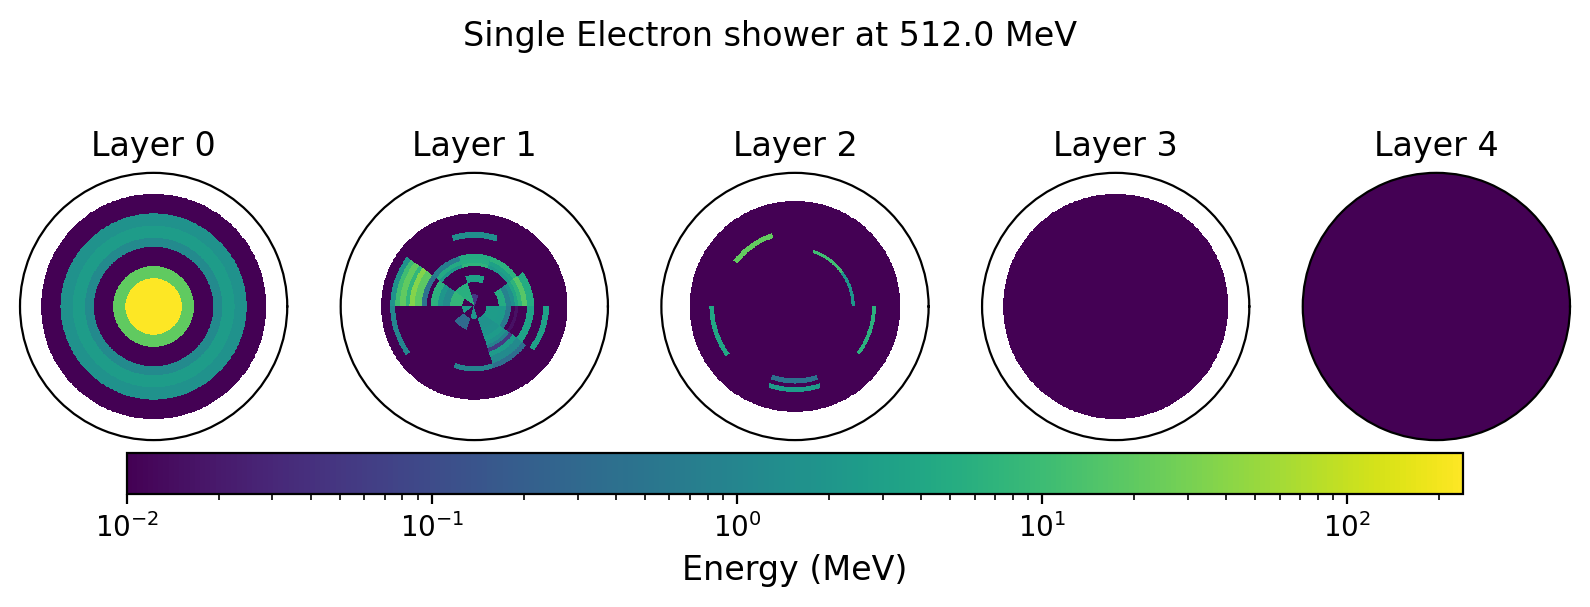

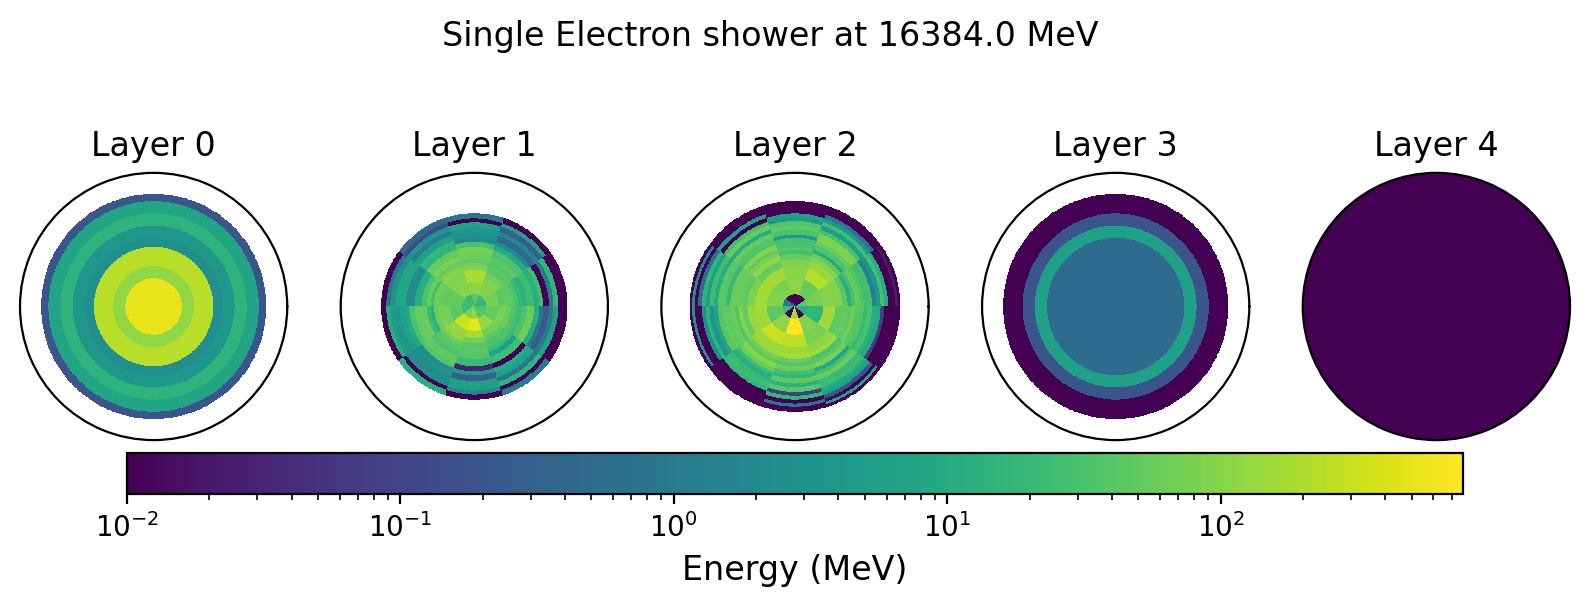

In [23]:
for i in range(5):
    _ = HLF_1_photons.DrawSingleShower(photon_file['showers'][i], filename=None,
                                title="Single Electron shower at {:.1f} MeV".format(photon_file['incident_energies'][i][0]))

In [24]:
class DiHiggsDataset_Lorentz(Dataset):
    def __init__(self, filename_sig, filename_bkg, num_ev=-1):
        self.fsig = uproot.open(filename_sig)
        self.fbkg = uproot.open(filename_bkg)
        self.event_tree_sig = self.fsig['events']
        self.event_tree_bkg = self.fbkg['events']
        #event_tree = self.f['events']
        if(num_ev == -1) :
            self.n_events_sig = self.event_tree_sig.num_entries
            self.n_events_bkg = self.event_tree_bkg.num_entries
        else :
            self.n_events_sig = num_ev
            self.n_events_bkg = num_ev
        self.all_graphs = []
        for i in tqdm(range(self.n_events_sig)):
            self.all_graphs.append(self.get_single_event(i, self.event_tree_sig, sigflag=1))
        for i in tqdm(range(self.n_events_bkg)):
            self.all_graphs.append(self.get_single_event(i, self.event_tree_bkg, sigflag=0))
        for i in range(10) :
            random.shuffle(self.all_graphs)
        self.n_eff = len(self.all_graphs)
    def __len__(self):
             return self.n_eff
    def __getitem__(self, idx):
            return self.all_graphs[idx]
    def get_single_event(self, event_idx, event_tree, sigflag):
        # ------- building the input truth particle graph ---------- #
        pfjet  = event_tree['pfjets08'].array(entry_start=event_idx,entry_stop=event_idx+1,library='np')
        trkjet = event_tree['trkjets04'].array(entry_start=event_idx,entry_stop=event_idx+1,library='np')
        px   = np.concatenate([ pfjet['pfjets08.core.p4.px'][0], trkjet['trkjets04.core.p4.px'][0] ], axis=0)
        py   = np.concatenate([ pfjet['pfjets08.core.p4.py'][0], trkjet['trkjets04.core.p4.py'][0] ], axis=0)
        pz   = np.concatenate([ pfjet['pfjets08.core.p4.pz'][0], trkjet['trkjets04.core.p4.pz'][0] ], axis=0)
        mass = np.concatenate([ pfjet['pfjets08.core.p4.mass'][0], trkjet['trkjets04.core.p4.mass'][0] ], axis=0)
        energy = np.sqrt(px**2 + py**2 + pz**2 + mass**2)
        trk_two_sub = event_tree['trkjetsTwoSubJettiness04'].array(entry_start=event_idx,entry_stop=event_idx+1,library='np')
        trk_one_sub = event_tree['trkjetsOneSubJettiness04'].array(entry_start=event_idx,entry_stop=event_idx+1,library='np')
        pf_two_sub = event_tree['pfjetsTwoSubJettiness08'].array(entry_start=event_idx,entry_stop=event_idx+1,library='np')
        pf_one_sub = event_tree['pfjetsOneSubJettiness08'].array(entry_start=event_idx,entry_stop=event_idx+1,library='np')
        two_sub = np.concatenate([ pf_two_sub['pfjetsTwoSubJettiness08.tag'][0], trk_two_sub['trkjetsTwoSubJettiness04.tag'][0] ], axis=0)
        one_sub = np.concatenate([ pf_one_sub['pfjetsOneSubJettiness08.tag'][0], trk_one_sub['trkjetsOneSubJettiness04.tag'][0] ], axis=0)
        n_particles = len( mass )
        edge_p_to_p_start = torch.arange(n_particles).repeat(n_particles)
        edge_p_to_p_end = torch.repeat_interleave( torch.arange(n_particles),n_particles)
        gr = dgl.graph((edge_p_to_p_start, edge_p_to_p_end))
        gr.ndata['x'] = torch.stack(
                                    [torch.tensor(energy),
                                     torch.tensor(px),
                                     torch.tensor(py),
                                     torch.tensor(pz)
                                    ],dim=-1
                                    ).reshape(gr.num_nodes(),4,1).float()
        gr.ndata['h'] = torch.stack([
                                     torch.tensor(two_sub),
                                     torch.tensor(one_sub),
                                    ],dim=-1
                                    ).float()
        return {'gr' : gr,
                #'E'  : np.sum(energy),
                'type' : sigflag
               }